In [104]:
import tensorflow as tf
import numpy as np
import pandas as pd
tf.enable_eager_execution()
import importlib
import os

from matplotlib import pyplot as plt
%matplotlib notebook

from transliteration import data, train, model_one, script, decode, evaluate

In [2]:
importlib.reload(data)
batch_size = 256
train_dataset = data.make_dataset('../data/tfrecord/train.tfrecord',
                                  from_script='en',
                                  to_script='ja',
                                  batch_size=batch_size)
valid_dataset = data.make_dataset('../data/tfrecord/valid.tfrecord',
                                  from_script='en',
                                  to_script='ja',
                                  batch_size=batch_size)
test_dataset = data.make_dataset('../data/tfrecord/test.tfrecord',
                                 from_script='en',
                                 to_script='ja',
                                 batch_size=batch_size)

In [9]:
batch_size = 256
cmu_train_dataset = data.make_dataset('../data/tfrecord/cmu_train.tfrecord',
                                  from_script='en',
                                  to_script='cmu',
                                  batch_size=batch_size)
cmu_valid_dataset = data.make_dataset('../data/tfrecord/cmu_valid.tfrecord',
                                  from_script='en',
                                  to_script='cmu',
                                  batch_size=batch_size)
cmu_test_dataset = data.make_dataset('../data/tfrecord/cmu_test.tfrecord',
                                 from_script='en',
                                 to_script='cmu',
                                 batch_size=batch_size)

In [10]:
importlib.reload(model_one)
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred)
    return tf.reduce_mean(loss_ * mask)

encoder_config = model_one.Config(lstm_size=120,
                                  embedding_size=60,
                                  attention_size=None,
                                  vocab_size=script.SCRIPTS['en'].vocab_size)
decoder_config = model_one.Config(lstm_size=80,
                                  embedding_size=60,
                                  attention_size=60,
                                  attention='monotonic_bahdanau',
                                  vocab_size=script.SCRIPTS['ja'].vocab_size)
cmu_decoder_config = model_one.Config(lstm_size=80,
                                  embedding_size=60,
                                  attention_size=60,
                                  attention='monotonic_bahdanau',
                                  vocab_size=script.SCRIPTS['cmu'].vocab_size)
encoder = model_one.Encoder(encoder_config)
decoder = model_one.Decoder(decoder_config)
cmu_decoder = model_one.Decoder(cmu_decoder_config)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder,
                                 cmu_decoder=cmu_decoder)

In [47]:
importlib.reload(train)
best_val_loss = None
for e in range(1):
    loss = train.run_one_epoch(cmu_train_dataset,
                               True,
                               from_script='en',
                               to_script='cmu',
                               encoder=encoder,
                               decoder=cmu_decoder,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(cmu_valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='cmu',
                                     encoder=encoder,
                                     decoder=cmu_decoder,
                                     loss_function=loss_function)
    if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='cmu',
                               encoder=encoder,
                               decoder=cmu_decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Epoch 0: Train Loss 2.218, Valid Loss 2.313
([['D EH1 R IH0 K IH0 NG', 'D EH1 R IH0 K AH0 CH ER0']], array([[-4.38515372, -6.12553985]]))


In [ ]:
importlib.reload(train)
best_val_loss = None
for e in range(1):
    loss = train.run_one_epoch(train_dataset,
                               True,
                               from_script='en',
                               to_script='ja',
                               encoder=encoder,
                               decoder=decoder,
                               train_encoder=False,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='ja',
                                     encoder=encoder,
                                     decoder=decoder,
                                     loss_function=loss_function)
    if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='ja',
                               encoder=encoder,
                               decoder=decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

In [49]:
importlib.reload(train)
best_val_loss = None
for e in range(1):
    loss = train.run_one_epoch(train_dataset,
                               True,
                               from_script='en',
                               to_script='ja',
                               encoder=encoder,
                               decoder=decoder,
                               train_encoder=True,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='ja',
                                     encoder=encoder,
                                     decoder=decoder,
                                     loss_function=loss_function)
    if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='ja',
                               encoder=encoder,
                               decoder=decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Epoch 0: Train Loss 3.120, Valid Loss 4.793
([['デリック', 'デリク']], array([[-2.34668241, -3.37643182]]))


In [44]:
checkpoint.restore(checkpoint_prefix + '-26').assert_consumed()
# train.run_one_epoch(valid_dataset,
#                     False,
#                     from_script='en',
#                     to_script='ja',
#                     encoder=encoder,
#                     decoder=decoder,
#                     loss_function=loss_function)

<tf.Tensor: id=129273772, shape=(), dtype=float32, numpy=4.719208>

In [77]:
valid_df = pd.read_csv('../data/split/pairs_valid.csv',
                       keep_default_na=False)

In [119]:
importlib.reload(decode)
tr = decode.transliterate(input_strs=valid_df['en'].values,
                     from_script='en',
                     to_script='ja',
                     encoder=encoder,
                     decoder=decoder,
                     k_best=20,
                     num_beams=40,
                     decoding_method=decode.beam_search_decode)

In [120]:
importlib.reload(evaluate)

ks = list(range(1, 21))
accuracies = [evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=k) for k in ks]

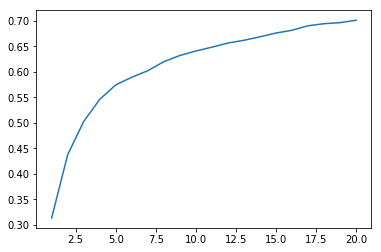

In [121]:
plt.plot(ks, accuracies)

In [122]:
importlib.reload(evaluate)
evaluate.mrr(valid_df['ja'].values,
             tr,
             k=20)

0.4267299118022281